# Predicting California Housing Prices
We will use the California Housing Prices dataset. This dataset was based on data from the 1990 California census. It is not exactly recent, but it has many qualities for learning, so we will pretend it is recent data.

Dataset columns description:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

In [80]:
# Data manipulation and Linear Algebra
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Sklearn for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
# load data
df = pd.read_csv('housing.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


##### Some Insights:
- we have 10 columns (9 numerical, and 1 categorical).
- we have 20640 rows.
- we have missing data in total_bedrooms.

In [5]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


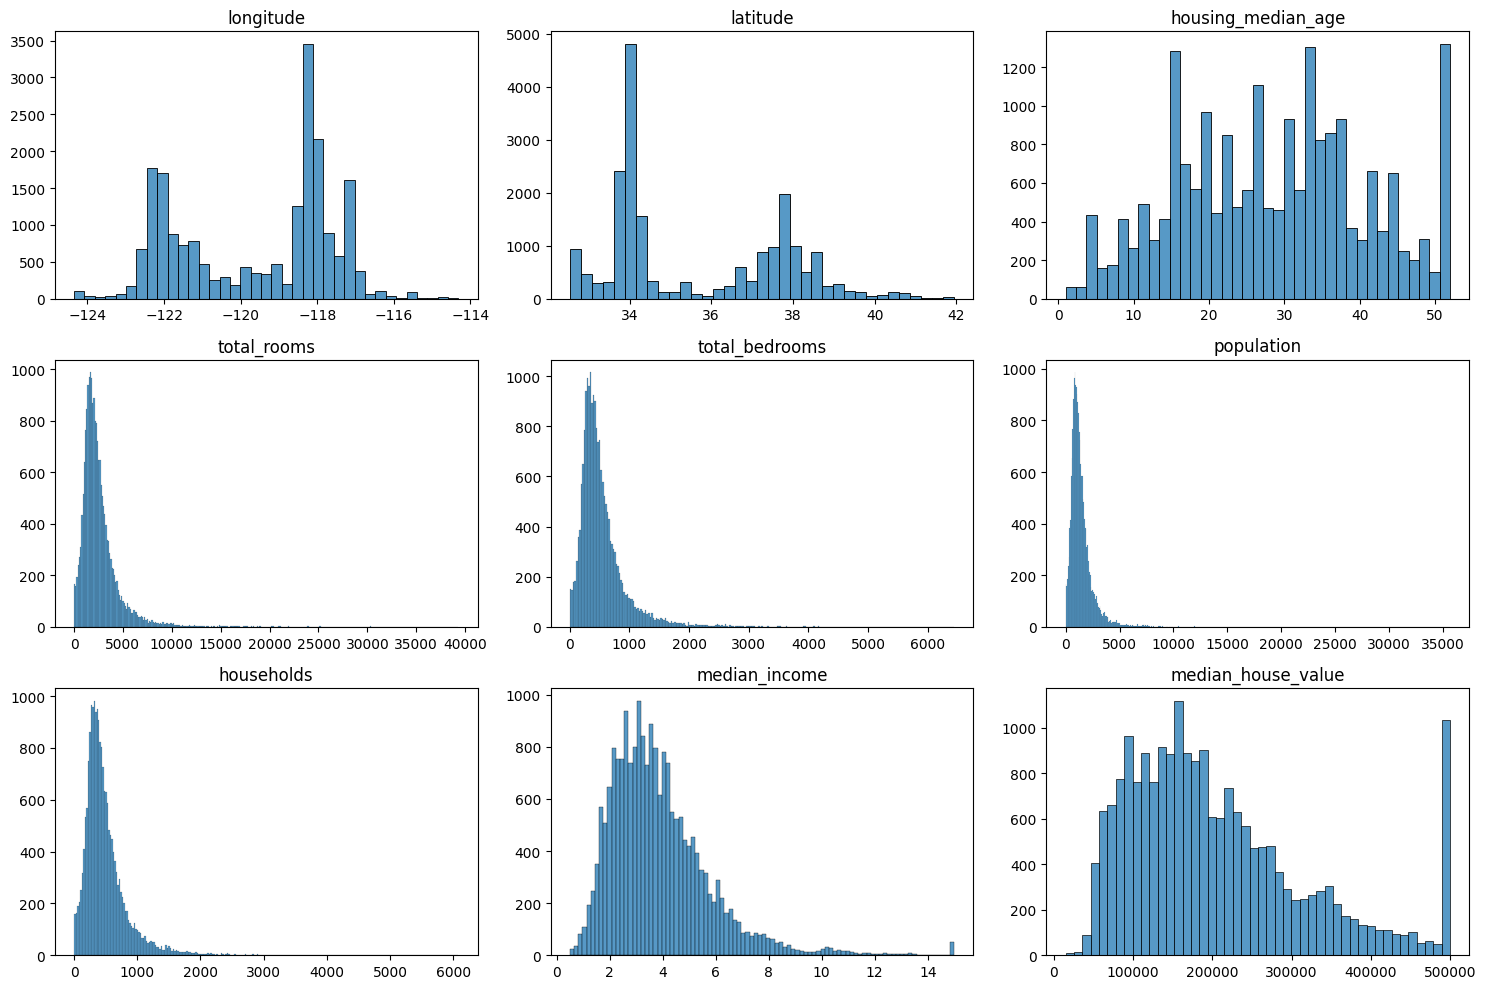

In [7]:
# Plot Histograms to know more about the numerical data distrbutions.
fig, axes = plt.subplots(3,3, figsize=(15, 10))
num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

for name, ax in zip(num_cols, axes.flatten()):
    sns.histplot(df[name], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
plt.tight_layout()
plt.show()

##### Some Insights:
- Median Income isn't look like US Dollars (it ranges from 0.5 to 15), and after searching it may be divided by 10000$ and capped the values bigger than 15 to 15.
- There are tall bars in the max value of median_house_value and housing_median_ages and that indicator of capping the values of the houses expencive more than 500K $ and older than 50 years old, and that's can be a problem because our problem might learn there isn't prices can't exceed 500k dollars, Maybe we will need to remove these capped rows to not bad influence our model.
- Many histograms are tail heavy: they extend much farther to the right of the median than to the left. 

In [8]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

#### Train test split:
It's good to split our data to train and test sets, as soon as possiable to prevent what called data snoping bias.

In [9]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)
df = train_set.copy()

### 1. Data Preproccessing:

#### 1.1 Checking for Dublicates:

In [10]:
print("Number of Duplicates: ", df.duplicated().sum())

Number of Duplicates:  0


#### 1.2 Checking for Outliers:

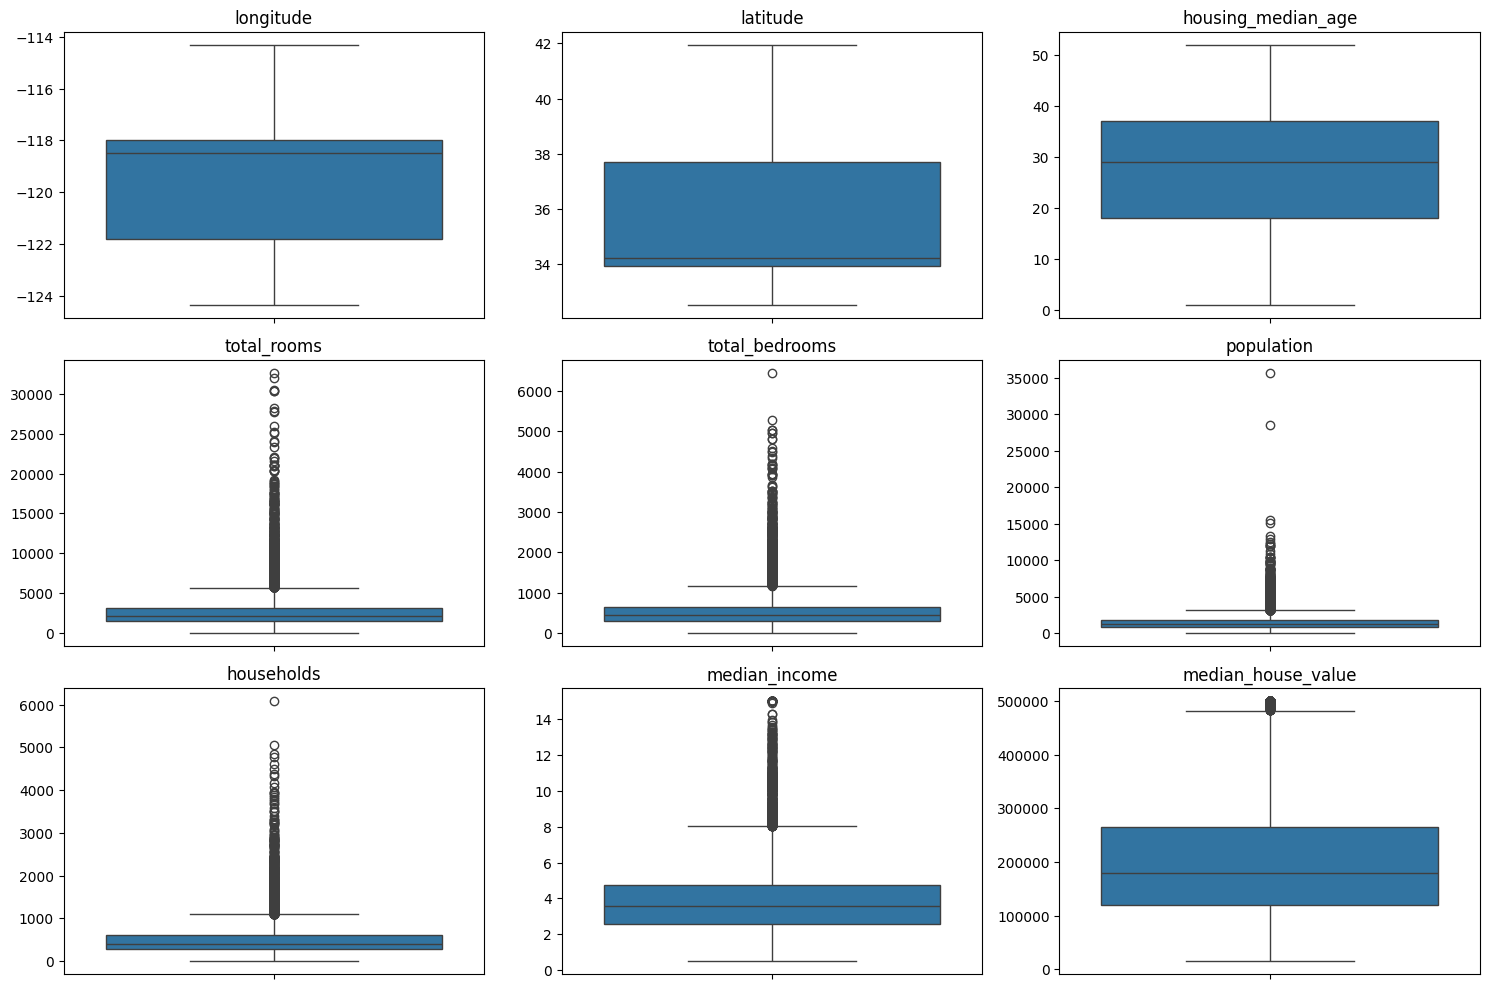

In [11]:
# Plot Histograms to know more about the numerical data distrbutions.
fig, axes = plt.subplots(3,3, figsize=(15, 10))
num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

for name, ax in zip(num_cols, axes.flatten()):
    sns.boxplot(df[name], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
plt.tight_layout()
plt.show()

Okay, As before we have upperbonds outliers in (total rooms, total bedrooms, population, households, median income). I think (total rooms, total bedrooms) is really dependant on number of households on the district. And I think there is a big correlations between (total rooms, total bedrooms, population, households, median income).

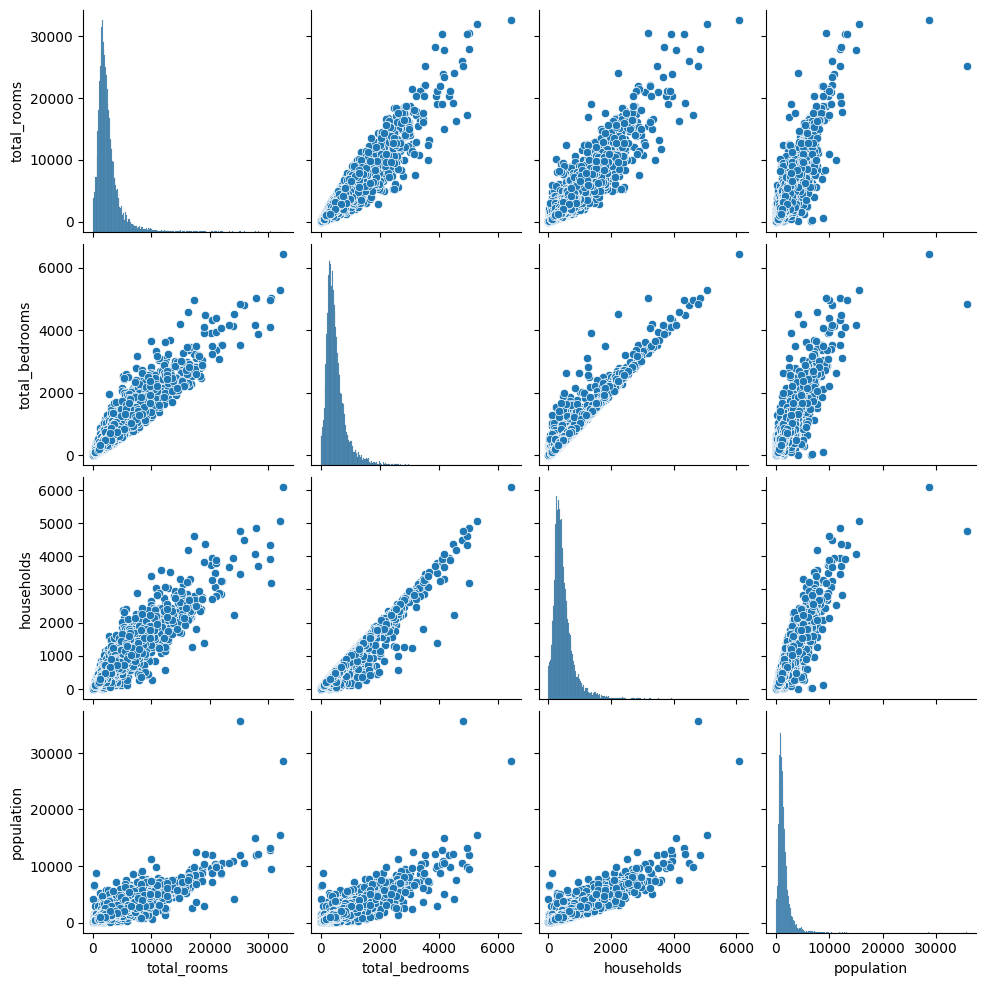

In [12]:
sns.pairplot(df[['total_rooms', 'total_bedrooms', 'households', 'population']])
plt.show()

Great, I think our hypothesis is right, there is a big correlation between (total rooms, total bedrooms, population, households, median income), so we can deal with it later using ratios between these features.

#### 1.3 Checking for Missing Data:

In [13]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [18]:
print(f"Percentage of missing values in total bedrooms: {(df['total_bedrooms'].isna().sum()/df.shape[0])*100}%")

Percentage of missing values in total bedrooms: 0.9568798449612402%


We have a missing values on total bedrooms, and it's very small percantage of our data, We can handle it using 2 methods:

1- Drop these rows, it's very small portion of our data.

2- As we have seen before their is a big correlation between total_bedrooms and other features and we can perdict the missing values by those.
We will handle it later.

### 2. EDA:

#### 2.1 Explore target varible (dependent variable):

In [22]:
df['median_house_value'].head()

12069    500001.0
15925    270000.0
11162    196100.0
4904     118800.0
4683     225000.0
Name: median_house_value, dtype: float64

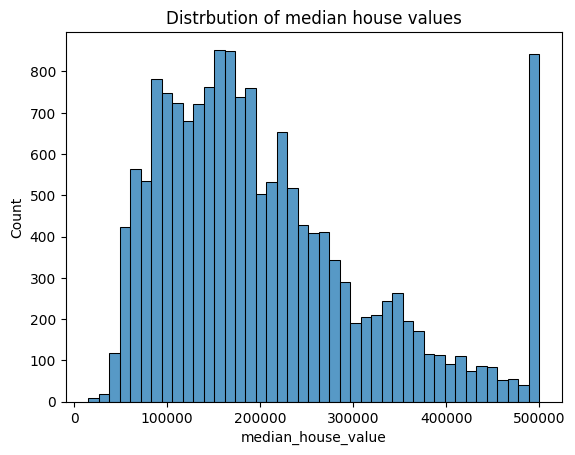

In [23]:
sns.histplot(df['median_house_value'])
plt.title('Distrbution of median house values')
plt.show()

I will remove the capped values at 500k $, because it can bad influnce our model.

In [24]:
df = df[df['median_house_value']<500000].copy()

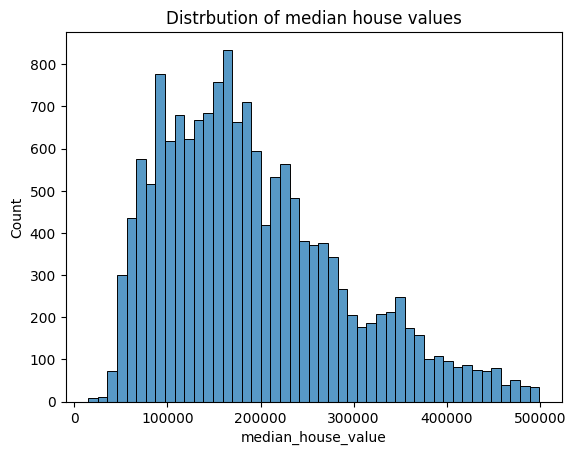

In [25]:
sns.histplot(df['median_house_value'])
plt.title('Distrbution of median house values')
plt.show()

#### 2.2 Explore indepandent varibles:

##### 2.2.1 ocean_proximity:

In [29]:
ocean_proximity_count = df['ocean_proximity'].value_counts().reset_index()

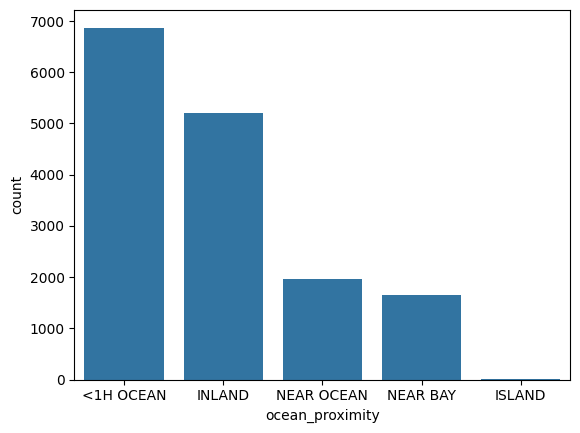

In [34]:
sns.barplot(ocean_proximity_count, x='ocean_proximity', y='count')
plt.show('ocean proximity categories count')
plt.show()

The most of our districts Inland or <1H from the Ocean, and we have very small numbers of districts in island, we will explore that more using lat, lon.

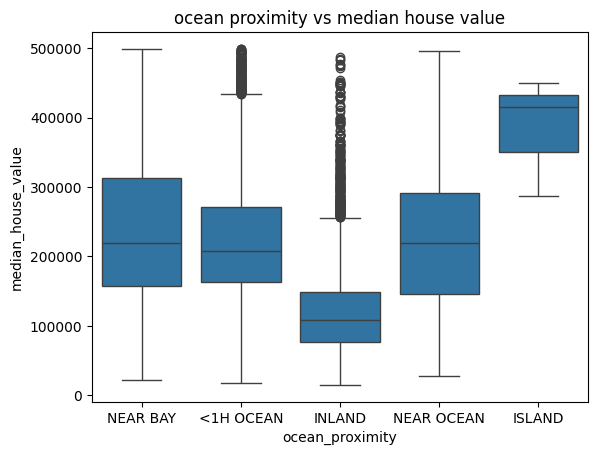

In [35]:
sns.boxplot(df, x='ocean_proximity', y='median_house_value')
plt.title('ocean proximity vs median house value')
plt.show()

We can see the districts in island are the most expensive, and Inland are the most cheap, and we can assume the ocean proximity is good predictor for our model.

Firstly we need to look on California map.


<img src="california-map.png" alt="Alt Text" width="500">

##### 2.2.2 longitude and latitude:

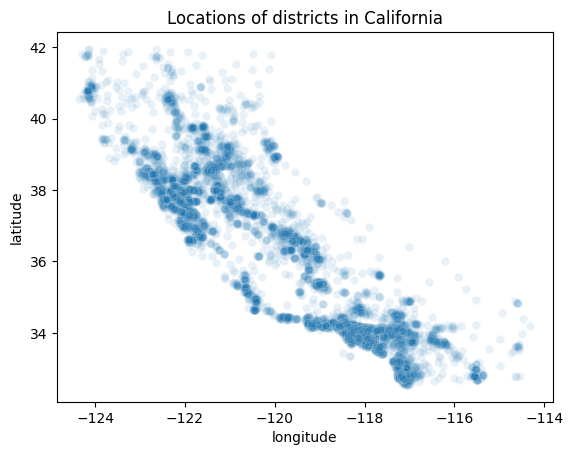

In [52]:
sns.scatterplot(df, x='longitude', y='latitude', alpha=0.1)
plt.title("Locations of districts in California")
plt.show()

We can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

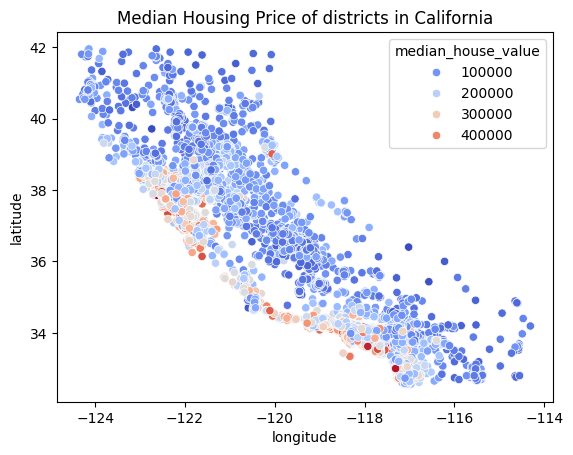

In [66]:
sns.scatterplot(df, x='longitude', y='latitude', alpha=1, hue='median_house_value', palette='coolwarm')
plt.title("Median Housing Price of districts in California")
plt.show()

As ocean_proximity, as we get near to the ocean the median prices of houses increases, but latitude and longitude give more informantion, It's clearly that, there are districts are more expensive than others like (Los Angeles, San Fransisco).

There isn't a mathematical relation between (latitude, longitude) and median_housing_price, maybe we can cluster these discrit.

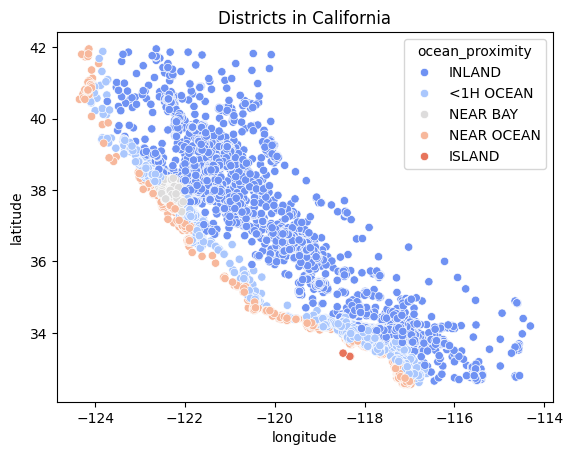

In [69]:
sns.scatterplot(df, x='longitude', y='latitude', alpha=1, hue='ocean_proximity', hue_order=['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN', 'ISLAND'],
                palette='coolwarm')
plt.title("Districts in California")
plt.show()

##### 2.2.3 other numerical variables:

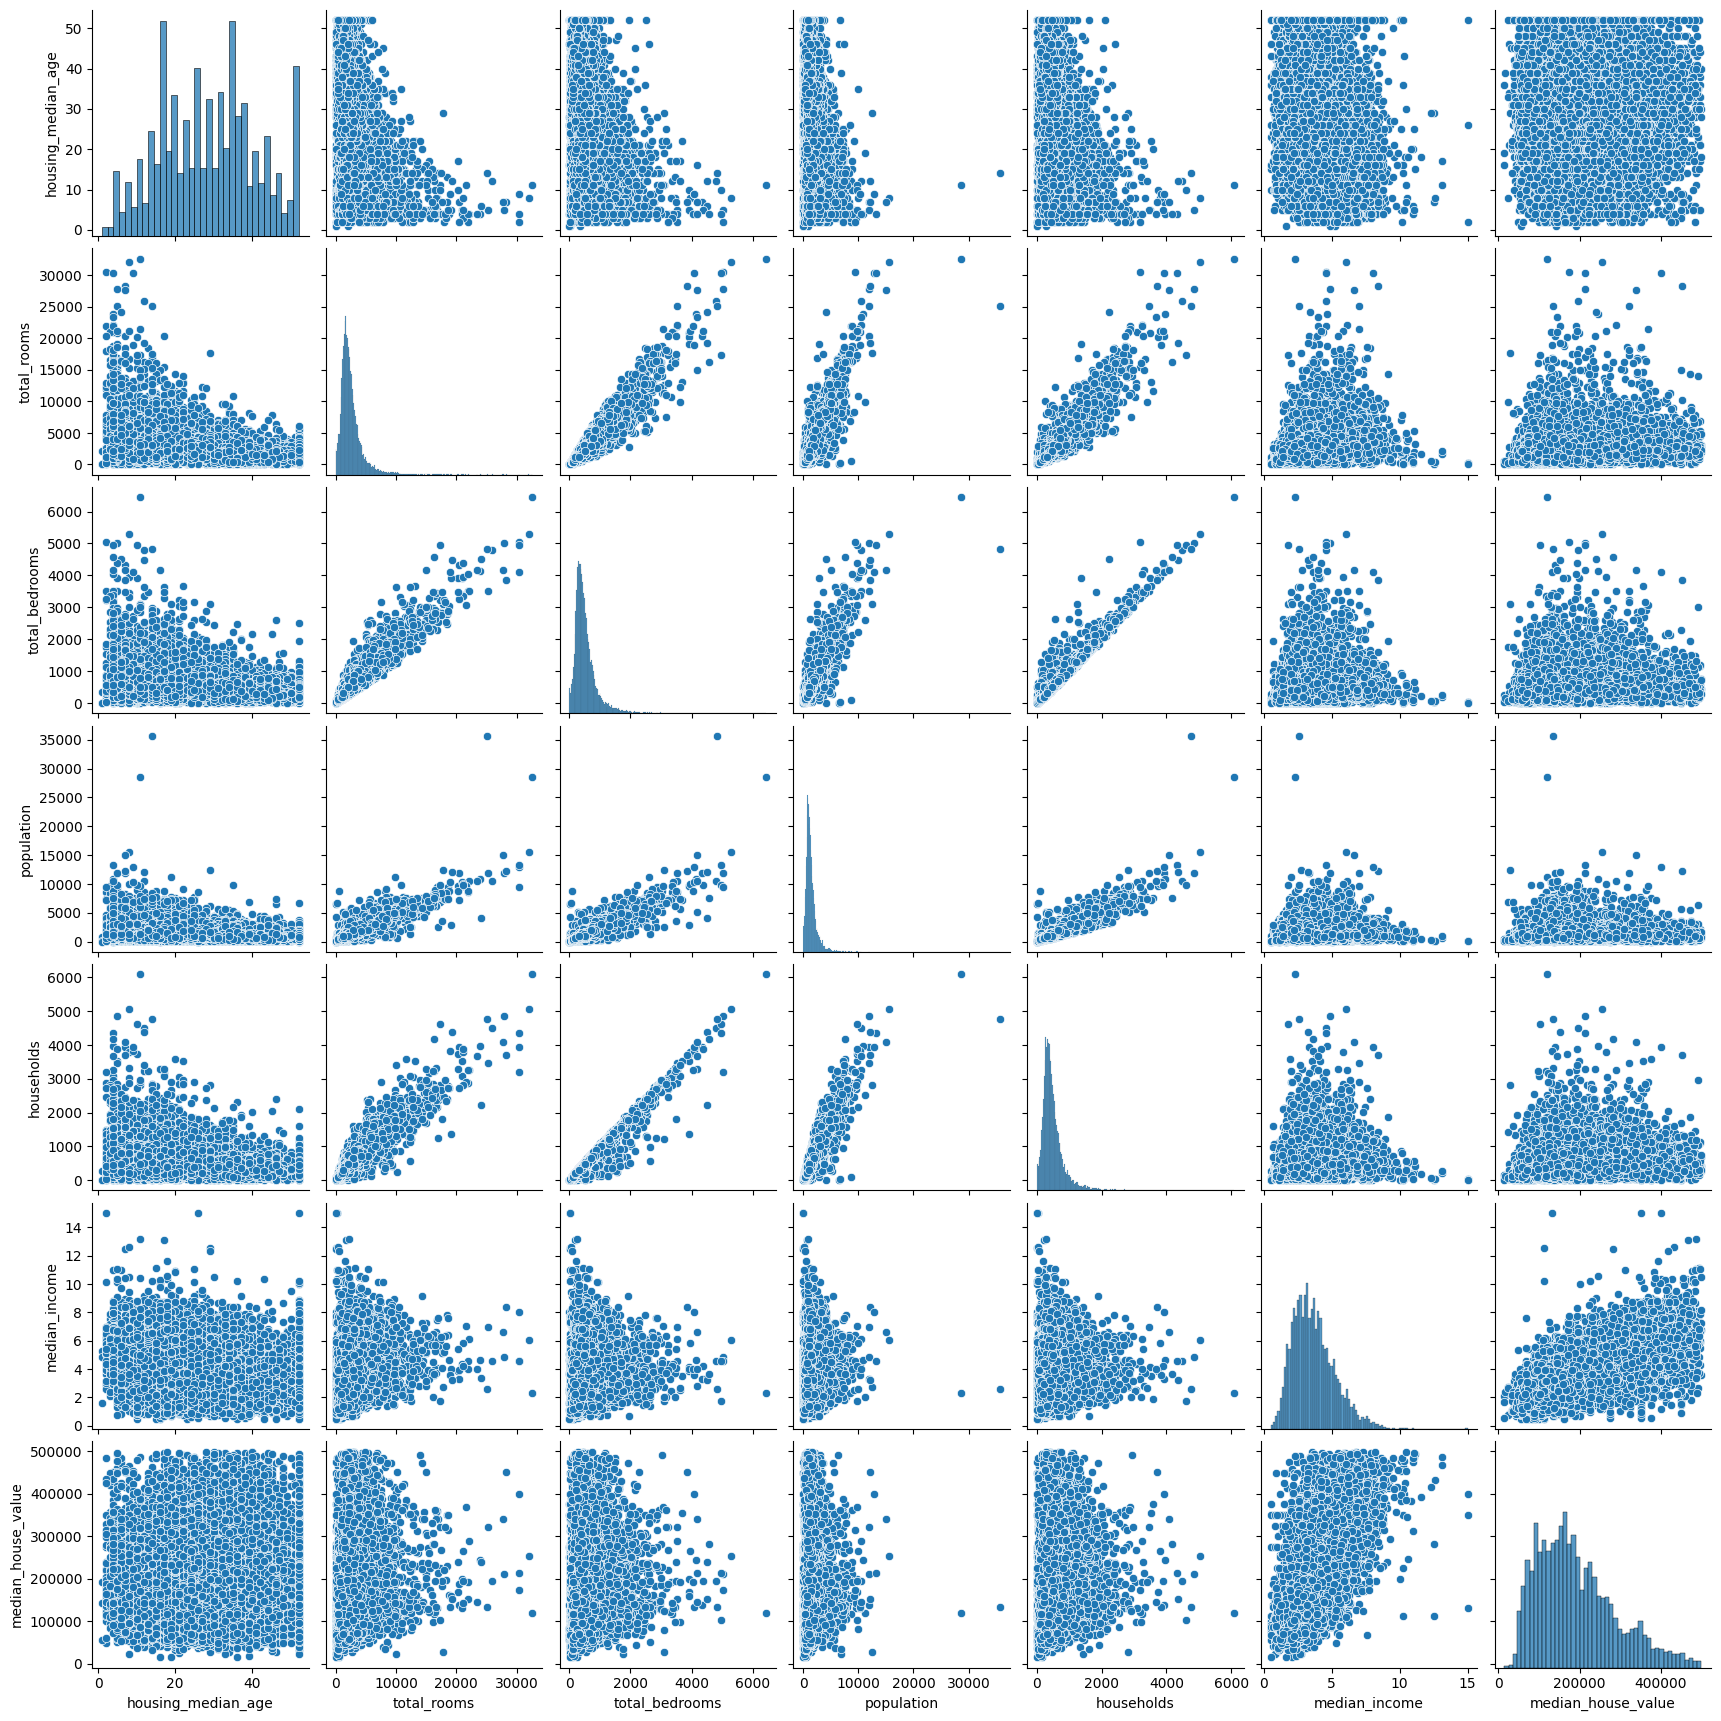

In [72]:
other_num = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
sns.pairplot(df[other_num])
plt.show()

In [73]:
correlation_matrix = df[other_num].corr()

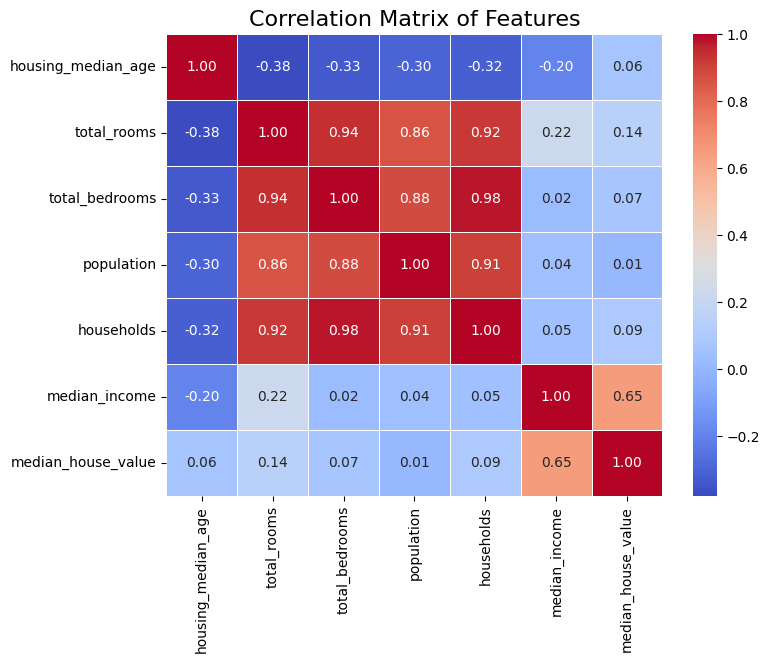

In [74]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


##### Some Insights:
- We have a very big correlations between (total_rooms, total_bedrooms, population, households) but they don't have correlation with median_house_value. (But I think with some scaling and feature engineering it will bring us with useful signals).
- Unexpectedly the housing_median_age seems like it's unuseful to predict median housing prices.
- We have a good correlation between median income and median house value.

### 3. Feature Engineering:

#### 3.1 Feature Exteraction:

I think the problem of the low correlations between (total_rooms, total_bedrooms, population, households) and median housing price is:

- The number of houses (households) or population in the district doesn't effect the house price, but the average number of people live in the same house might effect (population/households).

- The number of rooms of the district doesn't effect the house price, but the avarage number of rooms per house might effect.

So in the next section I will try to creaye more useful features for our target variable.

In [75]:
df['mean_people_per_house'] = df['population'] / df['households']
df['mean_rooms_per_house'] = df['total_rooms'] / df['households']
df['mean_bedrooms_per_house'] = df['total_bedrooms'] / df['households']
df['mean_people_per_room'] = df['population'] / df['total_rooms']
df['mean_people_per_bedroom'] = df['population'] / df['total_bedrooms']
df['total_bedrooms_total_rooms_ration'] = df['total_bedrooms'] / df['total_rooms']

In [78]:
new_features = ['mean_people_per_house', 'mean_rooms_per_house', 'mean_bedrooms_per_house', 'mean_people_per_room',
                'mean_people_per_bedroom', 'total_bedrooms_total_rooms_ration', 'median_house_value']

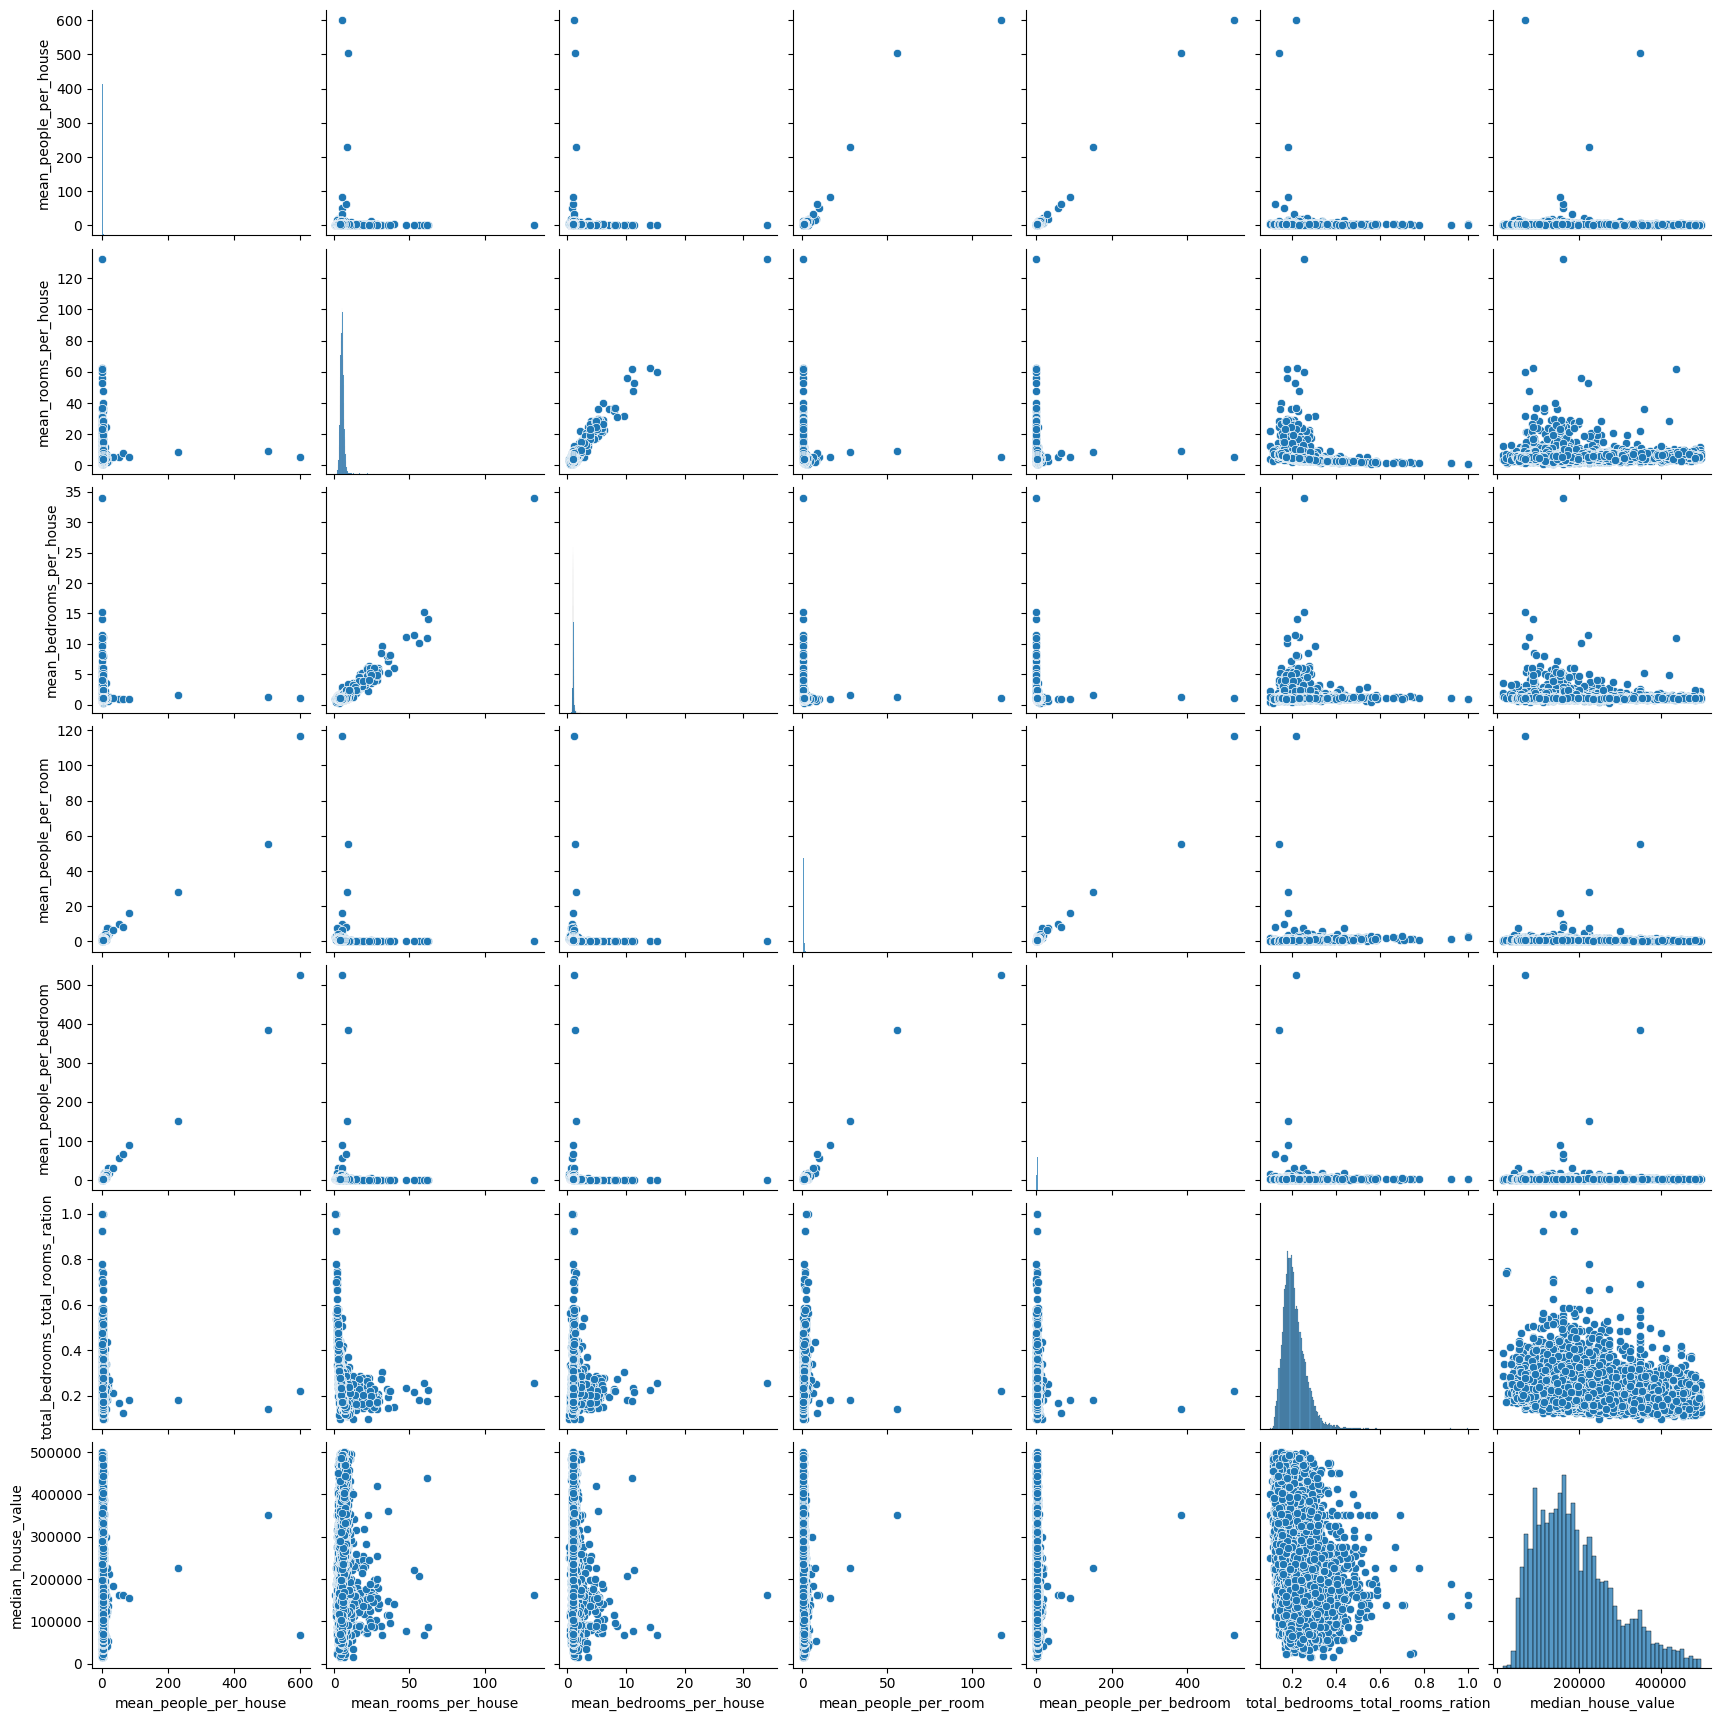

In [79]:
sns.pairplot(df[new_features])
plt.show()

In [82]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[new_features])
normalized_df = pd.DataFrame(normalized_data, columns=df[new_features].columns)

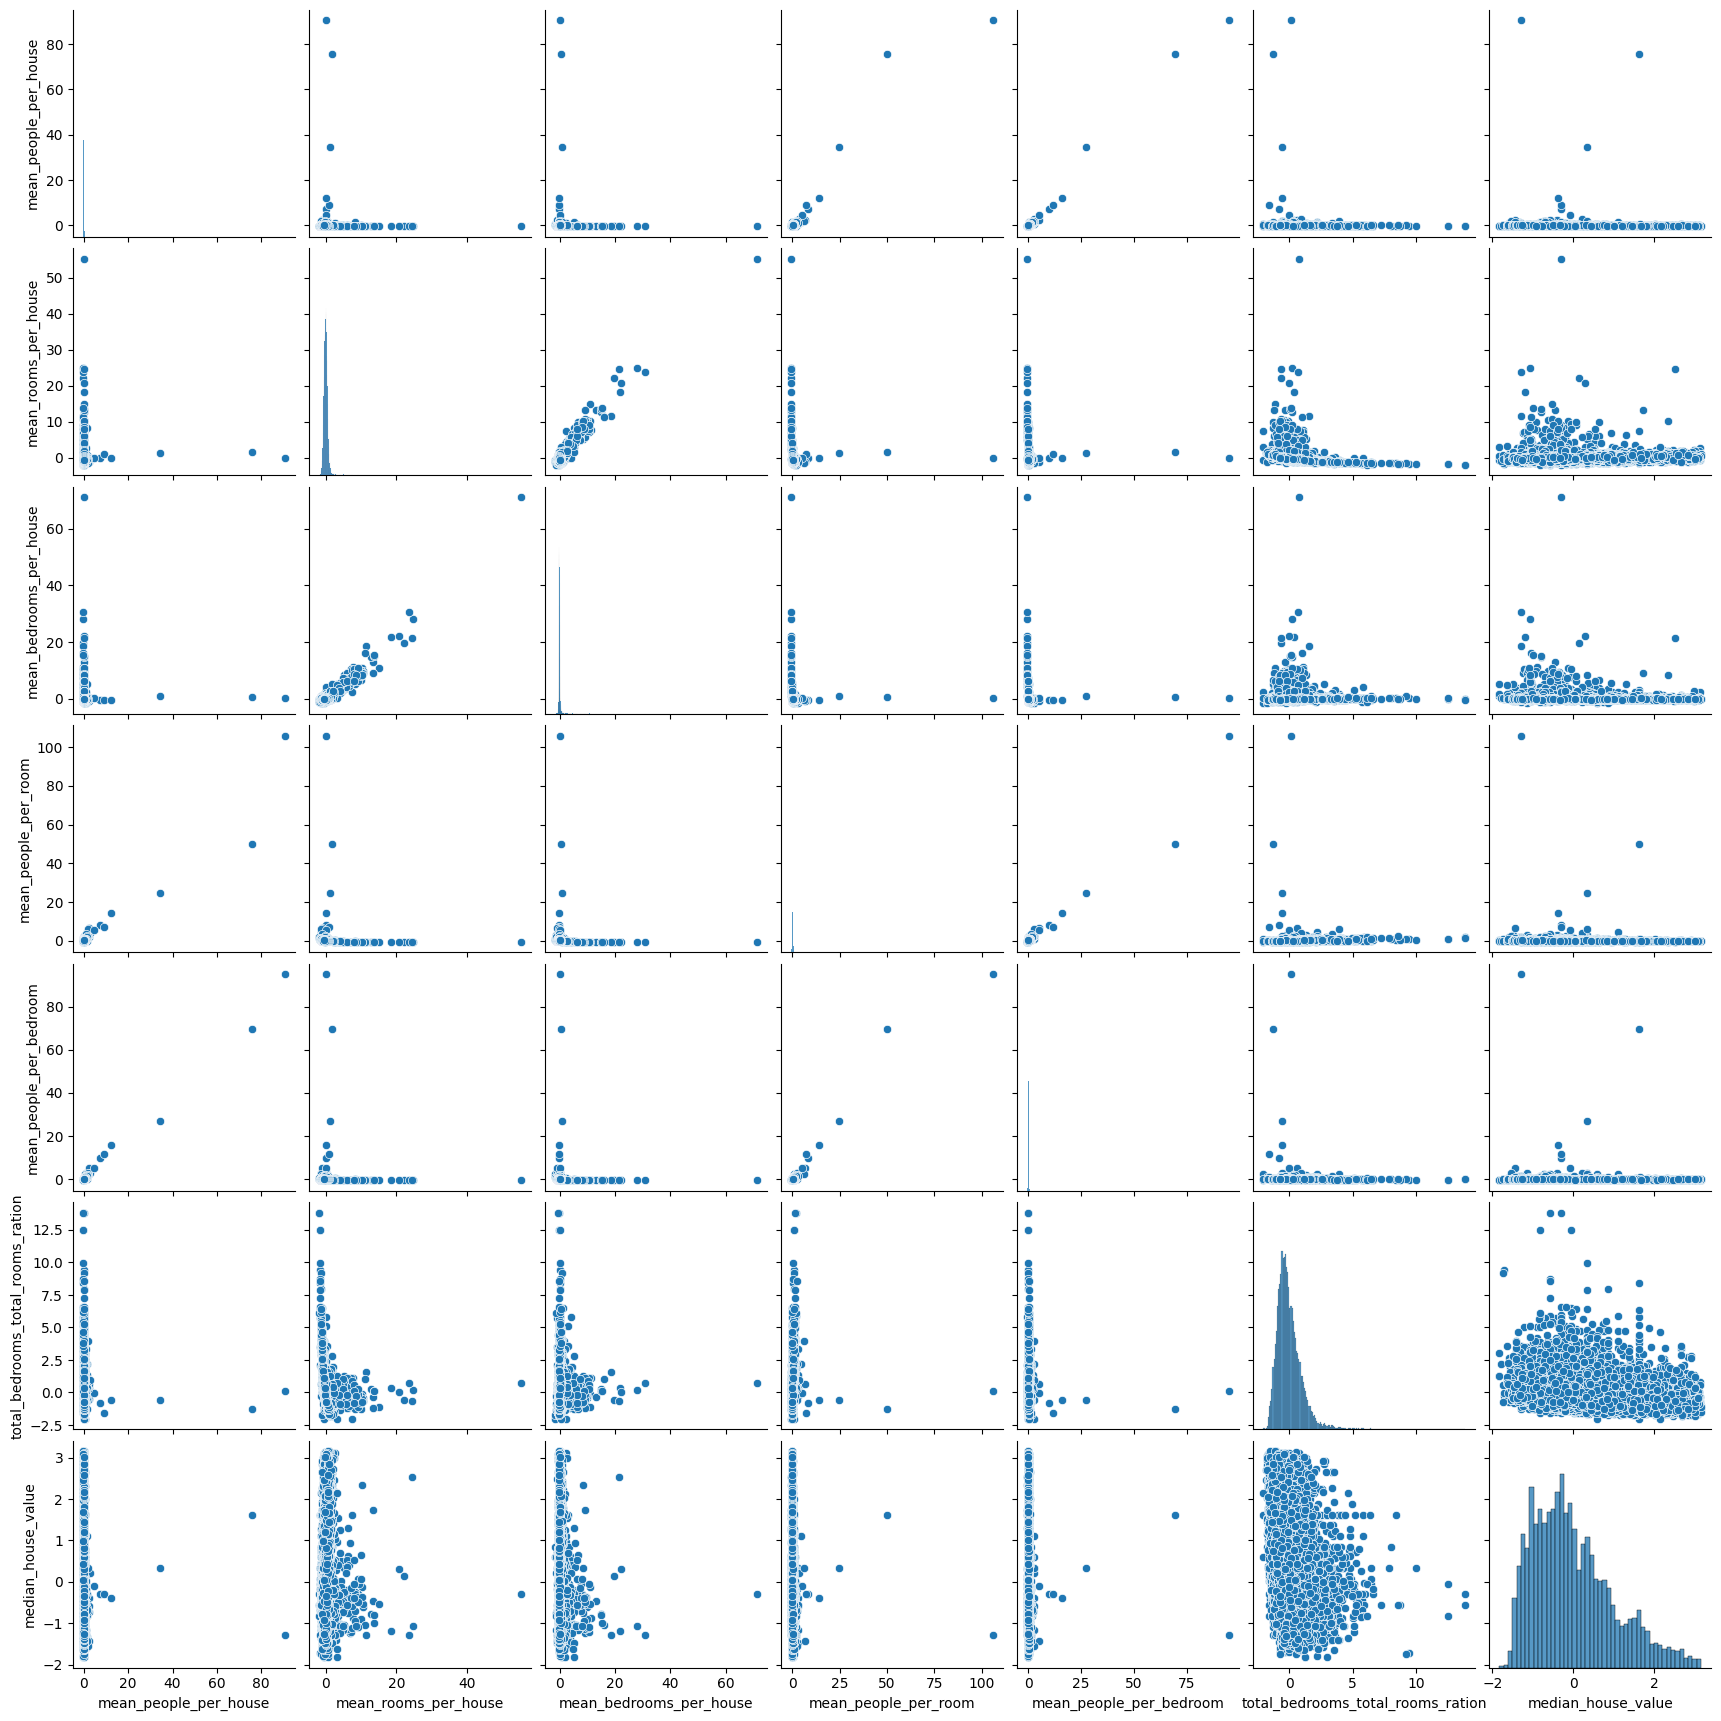

In [83]:
sns.pairplot(normalized_df)
plt.show()

In [84]:
correlation_matrix = normalized_df.corr()

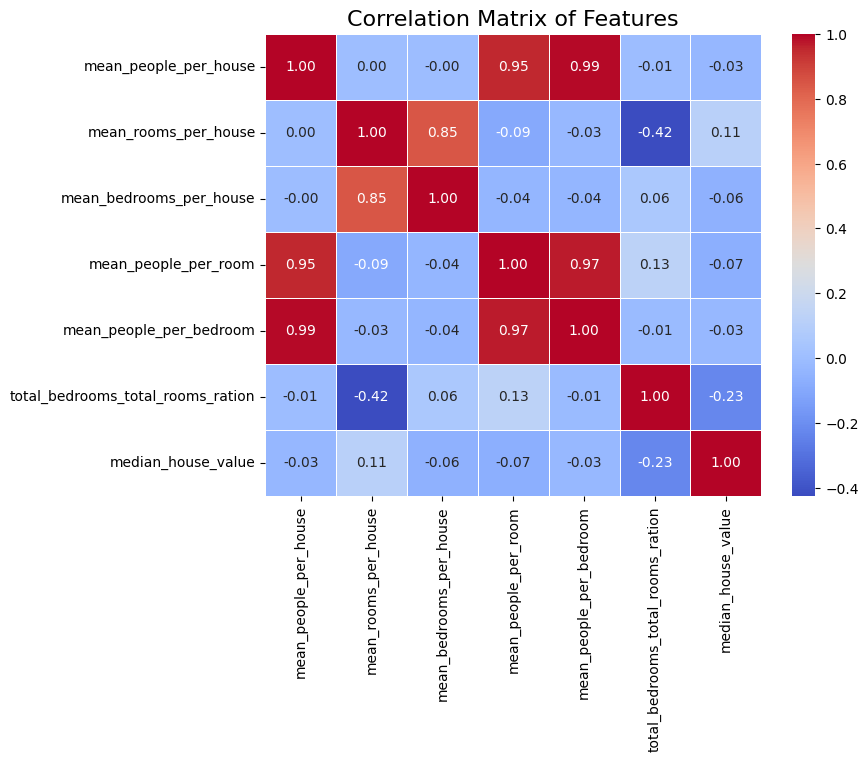

In [85]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()
